# Sensitivity analysis

In [69]:
from SALib.sample import saltelli, fast_sampler
from SALib.analyze import sobol, fast
from SALib.plotting.bar import plot as barplot
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# function for reading csv files
def pd_read_pattern(pattern, sep):
    files = glob.glob(pattern)
    df = pd.DataFrame()
    for f in files:
        df = df.append(pd.read_csv(f, sep=sep))
    return df.reset_index(drop=True)

# function to remove files
def removeFiles(pattern):
    files = glob.glob(pattern)
    for file in files:
        try:
            os.remove(file)
        except:
            print("Error while deleting file : ", file)

# read output files
def readOutput(read_raw_files, path, output_path, result_file_name, parameter_file_name):
    if (read_raw_files):
        df = pd_read_pattern(path + "group*.csv", sep=";")
        params = pd_read_pattern(path + "par*.csv", sep=";")
        df.iteration = df.iteration.astype(float)
        df = df.sort_values(by=['iteration'])
        df.to_csv(output_path + result_file_name + ".csv", index=False)
        params.to_csv(output_path + parameter_file_name + ".csv", index=False)
    else:
        df = pd.read_csv(output_path + result_file_name + ".csv")
    
    return df
        

In [2]:
# parameter dictionary
problem = {
    'num_vars': 3,
    'names': ['random-mating', 'leakage', 'fertility'],
    'bounds': [[0, 1],
               [0, 0.60],
               [0, 0.30]]
}

# Sobol

In [104]:
param_values = saltelli.sample(problem, 2**10)
t = pd.DataFrame(param_values)
t.columns = ["random-mating", "leakage", "fertility"]
t.to_csv("../models/fertility-BMI/data/param-sobol.csv", index=False)
len(t)

8192

In [127]:
df = readOutput(False, "../models/fertility-BMI/output/", "../output/data/", 
    "results-sobol", "param-anylogic-sobol")
Y = df.g4.to_numpy()
len(Y)

2048

In [128]:
Si = sobol.analyze(problem, Y, print_to_console=True)

                     ST   ST_conf
random-mating  0.338787  0.114160
leakage        0.703862  0.169493
fertility      0.499390  0.212333
                     S1   S1_conf
random-mating -0.020798  0.091502
leakage        0.387229  0.191287
fertility      0.241893  0.112536
                                  S2   S2_conf
(random-mating, leakage)    0.252645  0.252436
(random-mating, fertility)  0.068665  0.145133
(leakage, fertility)       -0.057559  0.245586


In [133]:
total, first, second = Si.to_df()

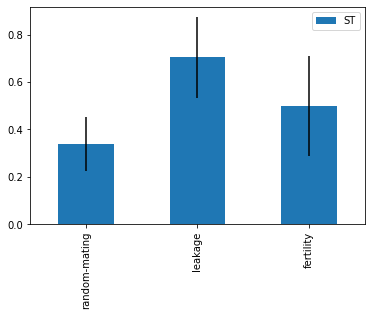

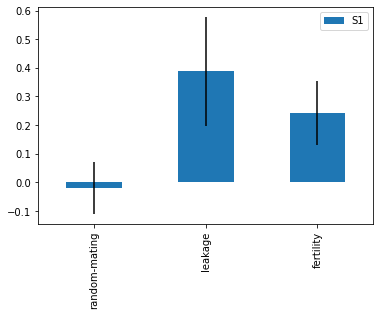

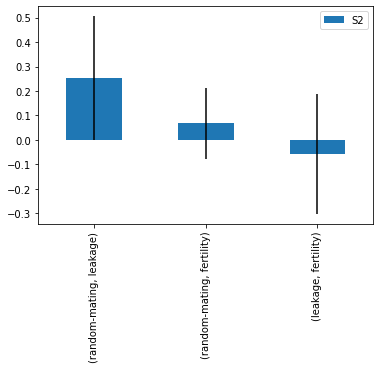

In [145]:
st = barplot(total)
plt.savefig("../output/plots/sobol-st.pdf", bbox_inches='tight')
s1 = barplot(first)
plt.savefig("../output/plots/sobol-s1.pdf", bbox_inches='tight')
s2 = barplot(second)
plt.savefig("../output/plots/sobol-s2.pdf", bbox_inches='tight')

# EFast

In [42]:
param_values = fast_sampler.sample(problem, 1000)

In [43]:
t = pd.DataFrame(param_values)
t.columns = ["random-mating", "leakage", "fertility"]
t.to_csv("../models/fertility-BMI/data/param-efast.csv", index=False)
len(t)

3000

In [44]:
df.columns

Index(['iteration', 'replicate', 'time', 'population', 'g1', 'g2', 'g3', 'g4',
       'mating', 'kid-father-cor', 'kid-mother-cor '],
      dtype='object')

In [80]:
df = readOutput(False, "../models/fertility-BMI/output/", "../output/data/", 
    "results-efast", "param-anylogic-efast")
Y = df["g4"].to_numpy()
len(Y)

3000

In [81]:
df.g4.describe()

count    3000.000000
mean        0.376931
std         0.126163
min         0.000000
25%         0.297823
50%         0.349927
75%         0.422917
max         0.977778
Name: g4, dtype: float64

In [82]:
Sif = fast.analyze(problem, Y, print_to_console=True)

                     S1        ST   S1_conf   ST_conf
random-mating  0.066447  0.356710  0.007181  0.026818
leakage        0.395304  0.714124  0.007663  0.026398
fertility      0.209558  0.424719  0.006490  0.025035


<AxesSubplot:>

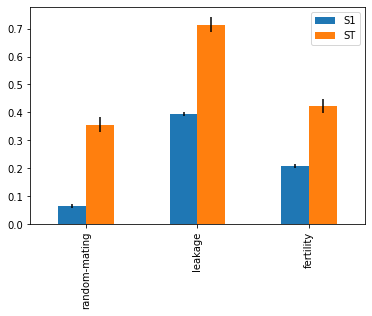

In [83]:
Sif.plot()

In [84]:

# 3D plot
x, y, z =  t["random-mating"], t["fertility"], t["leakage"]

fig = go.Figure(
    data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=4,
        color=Y,               
        colorscale= px.colors.sequential.OrRd,
        opacity=0.8
    )
)])

# tight layout

fig.update_layout(scene = dict(
                    xaxis_title='random mating',
                    yaxis_title='fertility',
                    zaxis_title='leakage'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
iplot(fig, image="png", filename="../output/plots/3D-scatterplot-efast.png")